## **Import libraries**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

#TODO: SAVE EACH MODEL

## **Upload dataset**

In [ ]:
dataset = pd.read_csv('DSL-StrongPasswordData.csv')
# 20400 x 34 
print(dataset.iloc[0:1,:])

In [60]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Split dataset into features (X) and labels (Y)
X = dataset.loc[:, "H.period":"H.Return"]

# Transorm labels to numeric format
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(dataset[["subject"]])

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) # stratify ensures class equal class distribution in sets

Hold Duration, Down-Down Duration and Up-Down Duration plots

In [ ]:
import seaborn as sns

unique_subjects = dataset['subject'].unique()
selected_subjects = unique_subjects[:5]

# Randomly select one row for each of the unique subjects
selected_data = dataset[dataset['subject'].isin(selected_subjects)].groupby('subject').sample(150)

fig, axes = plt.subplots(3, 1, figsize=(12, 15))
subplot_names = ["Hold Duration", "Down-Down Duration", "Up-Down Duration"]

for i, (col_name, marker) in enumerate([("H.Shift.r", 'o'), ("DD.Shift.r.o", 'o'), ("UD.Shift.r.o", 'o')]):
    ax = axes[i]
    ax.set_title(subplot_names[i]) 
    ax.set_xlabel('Users')
    ax.set_ylabel('Duration')

    # Create a subset of data with only the selected feature
    subset_data = selected_data[['subject', col_name]]

    sns.swarmplot(data=subset_data, x='subject', y=col_name, ax=ax, marker=marker)

plt.tight_layout()
plt.show()


# **Random Forest**

In [6]:
from sklearn.ensemble import RandomForestClassifier

# n_estimators - number of decision trees
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
predictions = rf.predict(X_test)

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R-squared (R2): {r2}")
print(classification_report(y_test, predictions))

In [ ]:
hyperparams = {
    'n_estimators': list(range(10, 200)),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4], 
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier()

# cv - cross validation
grid_search = GridSearchCV(rf, hyperparams, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print('Best hyperparams:', grid_search.best_estimator_.get_params())

In [106]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R-squared (R2): {r2}")
print(classification_report(y_test, predictions))

Mean Squared Error: 0.006189926951172627
R-squared (R2): 0.6819335300147356
Accuracy: 0.6872549019607843

              precision    recall  f1-score   support

           0       1.00      0.43      0.60        89
           1       0.97      0.71      0.82        79
           2       1.00      0.62      0.77        80
           3       1.00      0.83      0.91        82
           4       1.00      0.52      0.68        79
           5       1.00      0.43      0.61        76
           6       1.00      0.83      0.91        75
           7       1.00      0.70      0.82        86
           8       0.98      0.70      0.82        70
           9       1.00      0.79      0.88        70
          10       1.00      0.35      0.52        86
          11       0.99      0.75      0.86       102
          12       1.00      0.88      0.94        82
          13       0.99      0.72      0.83        92
          14       1.00      0.92      0.96        78
          15       1.00      

/Users/zpietrza/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


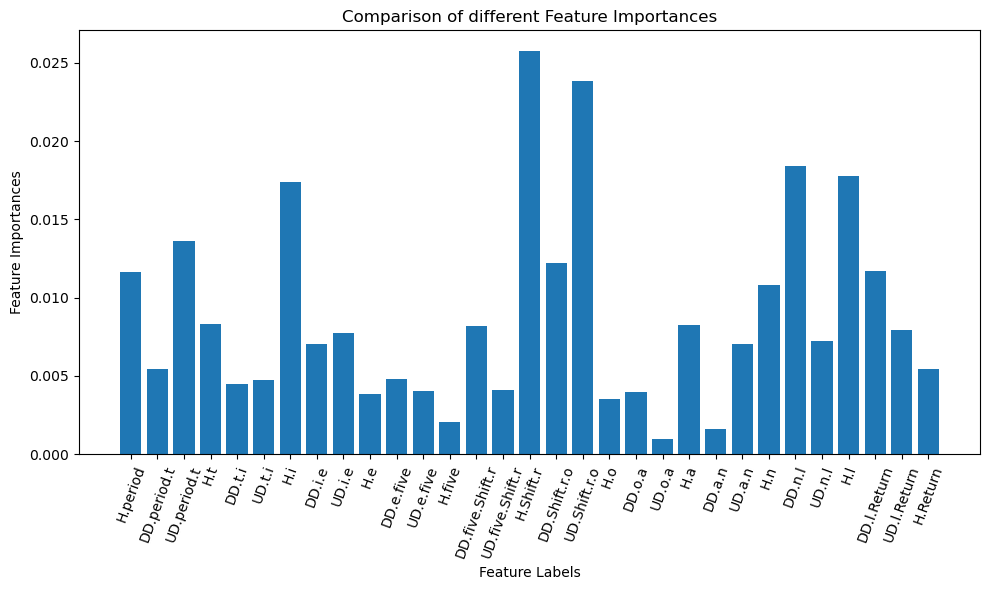

In [107]:
from sklearn.ensemble import ExtraTreesClassifier
extra_tree_forest = ExtraTreesClassifier(n_estimators = 5, criterion ='entropy', max_features = 30)

extra_tree_forest.fit(X, y)

feature_importance = extra_tree_forest.feature_importances_

feature_importance_normalized = np.std([tree.feature_importances_ for tree in extra_tree_forest.estimators_], axis = 0)


plt.figure(figsize=(10, 6))
plt.bar(X.columns, feature_importance_normalized)
plt.xticks(rotation=70)

plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.tight_layout()
plt.show()

# **K Nearest Neighbors**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier 

X_train = np.array(X_train)
X_test = np.array(X_test)

neighbors = np.arange(1, 20) 
train_accuracy_eu = np.empty(len(neighbors)) 
test_accuracy_eu = np.empty(len(neighbors)) 
train_accuracy_man = np.empty(len(neighbors)) 
test_accuracy_man = np.empty(len(neighbors)) 

for i, k in enumerate(neighbors): 
    # default, euclidean metric
    knn_eu = KNeighborsClassifier(n_neighbors=k) 
    knn_eu.fit(X_train, y_train) 

    # manhattan metric
    knn_man = KNeighborsClassifier(n_neighbors=k, metric="manhattan") 
    knn_man.fit(X_train, y_train) 

    train_accuracy_eu[i] = knn_eu.score(X_train, y_train) 
    test_accuracy_eu[i] = knn_eu.score(X_test, y_test) 
    train_accuracy_man[i] = knn_man.score(X_train, y_train) 
    test_accuracy_man[i] = knn_man.score(X_test, y_test) 

plt.plot(neighbors, test_accuracy_eu, label = 'Testing dataset Accuracy - Euclidean metric') 
plt.plot(neighbors, train_accuracy_eu, label = 'Training dataset Accuracy - Euclidean metric') 
plt.plot(neighbors, test_accuracy_man, label = 'Testing dataset Accuracy - Manhattan metric') 
plt.plot(neighbors, train_accuracy_man, label = 'Training dataset Accuracy - Manhattan metric') 
plt.legend() 
plt.xlabel('n_neighbors') 
plt.ylabel('Accuracy') 

plt.tight_layout()
plt.show()  

In [109]:
knn = KNeighborsClassifier(n_neighbors=12, metric="manhattan") 
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=12)

In [110]:
predictions = knn.predict(X_test)

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R-squared (R2): {r2}")
print(classification_report(y_test, predictions))

#Mean Squared Error: 71.77892156862745
#R-squared (R2): 0.6635352014516545
#Accuracy: 0.8247549019607843

Mean Squared Error: 0.006660899653979239
R-squared (R2): 0.6553132371565145
Accuracy: 0.7017156862745098

              precision    recall  f1-score   support

           0       0.91      0.58      0.71        89
           1       1.00      0.61      0.76        79
           2       0.96      0.64      0.77        80
           3       0.92      0.87      0.89        82
           4       0.87      0.70      0.77        79
           5       0.86      0.57      0.68        76
           6       1.00      0.83      0.91        75
           7       1.00      0.67      0.81        86
           8       0.98      0.69      0.81        70
           9       0.88      0.80      0.84        70
          10       0.98      0.47      0.63        86
          11       0.95      0.79      0.87       102
          12       0.92      0.83      0.87        82
          13       0.98      0.58      0.73        92
          14       0.96      0.90      0.93        78
          15       1.00      

/Users/zpietrza/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
hyperparams = {
    'n_neighbors': list(range(2, 21)),
    'leaf_size': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2, 3]
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, hyperparams, cv=5, scoring='accuracy')
grid_search = grid_search.fit(X_train, y_train)

print('Best hyperparams:', grid_search.best_estimator_.get_params())

In [ ]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R-squared (R2): {r2}")
print(classification_report(y_test, predictions))

# **Neutral Network**

In [ ]:
%pip install tensorflow

Epoch 1/100
447/447 - 2s - loss: 2.9875 - accuracy: 0.2658 - val_loss: 2.1492 - val_accuracy: 0.5147 - 2s/epoch - 4ms/step
Epoch 2/100
447/447 - 1s - loss: 1.8420 - accuracy: 0.5555 - val_loss: 1.3957 - val_accuracy: 0.6997 - 903ms/epoch - 2ms/step
Epoch 3/100
447/447 - 1s - loss: 1.3397 - accuracy: 0.6616 - val_loss: 1.0852 - val_accuracy: 0.7471 - 817ms/epoch - 2ms/step
Epoch 4/100
447/447 - 1s - loss: 1.0843 - accuracy: 0.7188 - val_loss: 0.8602 - val_accuracy: 0.7922 - 812ms/epoch - 2ms/step
Epoch 5/100
447/447 - 1s - loss: 0.9133 - accuracy: 0.7604 - val_loss: 0.7272 - val_accuracy: 0.8212 - 787ms/epoch - 2ms/step
Epoch 6/100
447/447 - 1s - loss: 0.8035 - accuracy: 0.7846 - val_loss: 0.6330 - val_accuracy: 0.8425 - 792ms/epoch - 2ms/step
Epoch 7/100
447/447 - 1s - loss: 0.7172 - accuracy: 0.8038 - val_loss: 0.5741 - val_accuracy: 0.8448 - 801ms/epoch - 2ms/step
Epoch 8/100
447/447 - 1s - loss: 0.6547 - accuracy: 0.8176 - val_loss: 0.5544 - val_accuracy: 0.8500 - 796ms/epoch - 2ms/

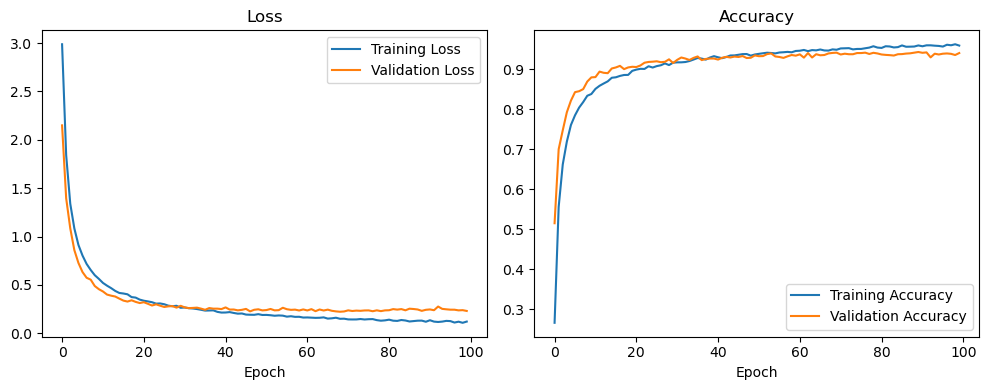

In [98]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import f1_score

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

model = Sequential()

model.add(Dense(256, input_dim=31, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='leaky_relu'))
model.add(Dropout(0.2))
model.add(Dense(51, activation='softmax'))

# metrics=['categorical_accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=100, verbose=2)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [99]:
predictions = model.predict(X_test)
predictions = (predictions > 0.95).astype(int)

f1 = f1_score(y_test, predictions, average='macro')
print(f'F1 Score (Macro): {f1}')

96/96 [==============================] - 0s 2ms/step
F1 Score (Macro): 0.9002280481883679


In [ ]:
from scipy.stats import entropy

users = dataset['subject'].unique()
entropy_values = []

for user in users:
    user_data = dataset[dataset['subject'] == user]
    feature_columns = X
    user_entropy = []
    for feature in feature_columns:
        user_entropy.append(entropy(user_data[feature]))
    entropy_values.append(user_entropy)

for i, user in enumerate(users):
    print(f'User {user} - Entropy: {entropy_values[i]}')

96/96 [==============================] - 0s 2ms/step


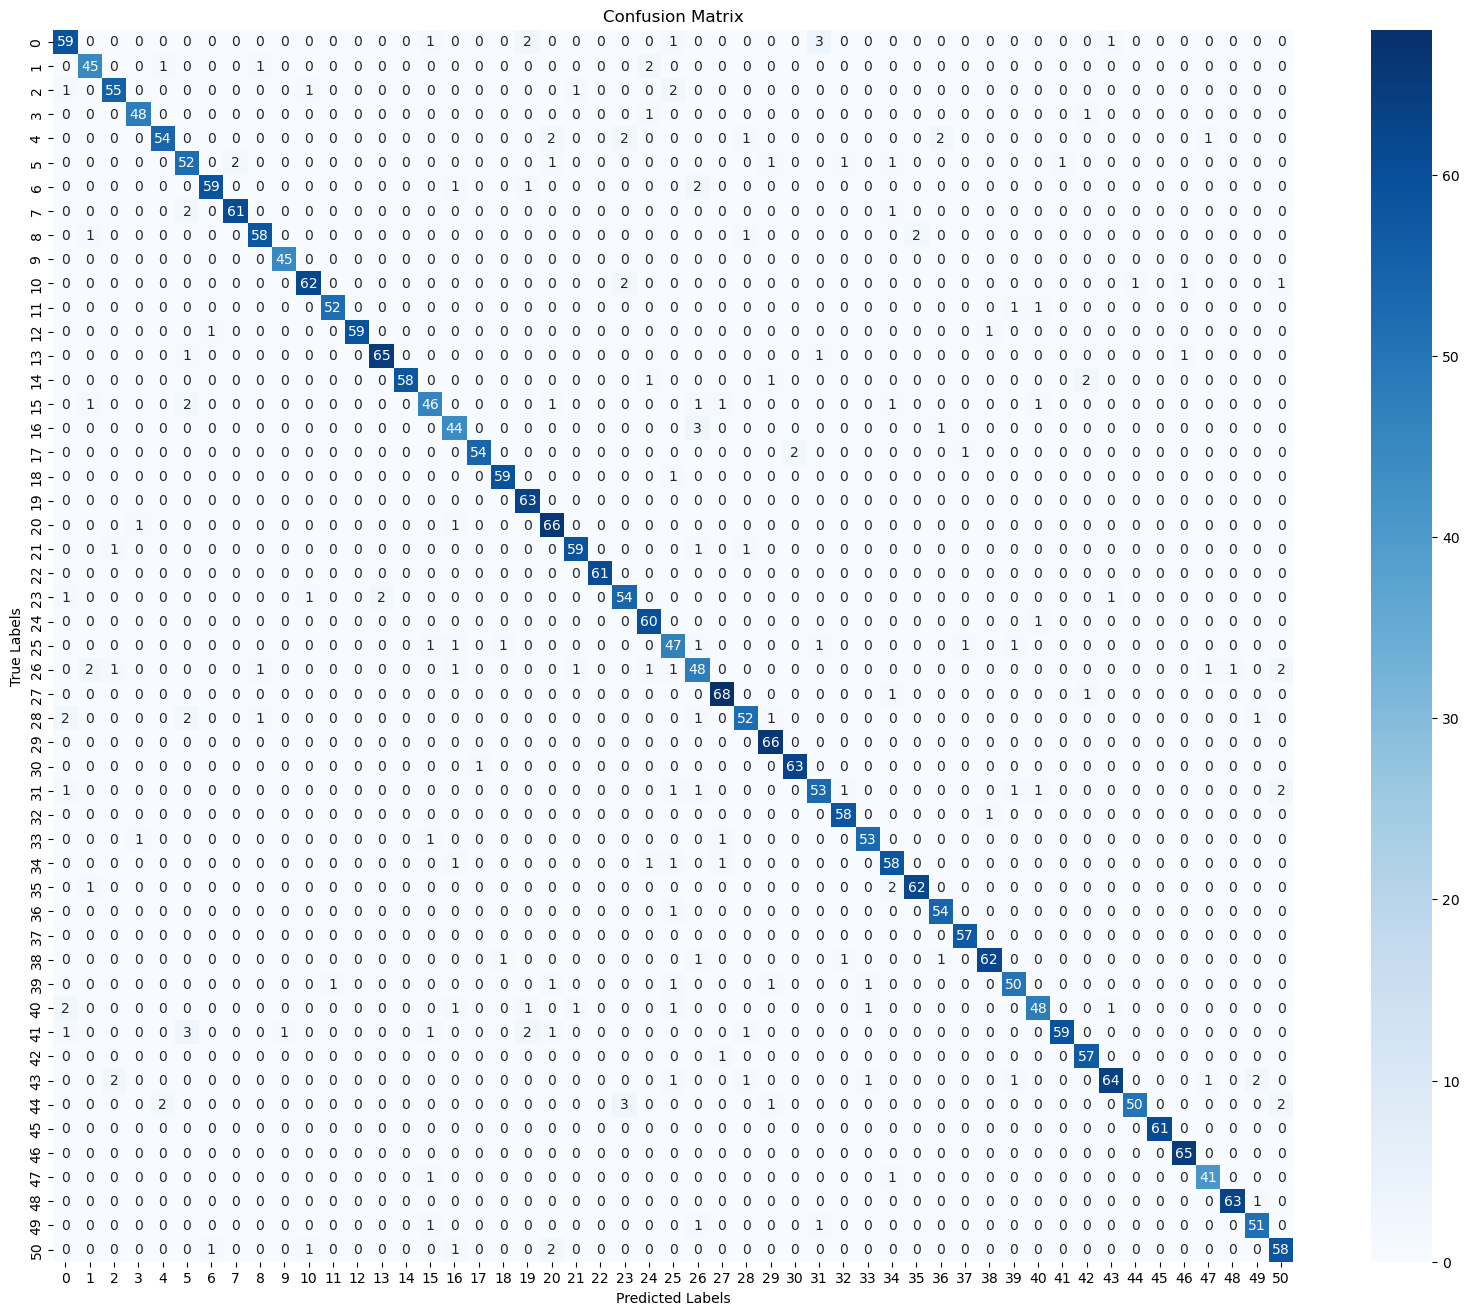

In [114]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()